In [ ]:
!git clone -b atm-10 http://github.com/Zapy67/ATML-PA-2

In [ ]:
!git pull http://github.com/Zapy67/ATML-PA-2 atm-10

In [ ]:
!pip install deeplake==3.9.16

In [5]:
ls 

input/  lib/  working/


In [2]:
cd ../

/kaggle


In [6]:
import torch
from torch import nn

class GaussianKernel(nn.Module):
    def __init__(self, sigma=1.0):
        super().__init__()
        self.sigma = sigma

    def forward(self, x, y):
        diff = x - y
        dist = torch.sum(diff ** 2, dim= tuple(range(1, x.dim())))
        return torch.exp(-dist / (2 * self.sigma ** 2))

class MKMMDLoss(nn.Module):        
        def __init__(self, sigmas_):
            super().__init__()
            self.sigmas_ = sigmas_
              
        def forward(self, H_s, H_t):
            assert len(H_s) == len(H_t)
            assert len(H_s) % 2 == 0

            half_size = len(H_s) // 2

            xs1, xs2 = H_s[0:half_size], H_s[half_size:]
            xt1, xt2 = H_t[0:half_size], H_t[half_size:]

            mmd2 = 0
            for sigma in self.sigmas_:
                k = GaussianKernel(sigma)
                k_ss = k(xs1, xs2)
                k_tt = k(xt1, xt2)
                k_st = k(xs1, xt2)
                k_ts = k(xs2, xt1)
                mmd2 += (k_ss + k_tt - k_st - k_ts).mean()
            
            return torch.clamp( 2* mmd2  / len(self.sigmas_), min=0)
        
class DANLoss(nn.Module):
        def __init__(self, sigmas, scale):
            super().__init__()
            self.sigmas = sigmas
            self.scale = scale
            self.mkmmd = MKMMDLoss(sigmas)
            self.supervised = torch.nn.CrossEntropyLoss()
              
        def forward(self, source_features, target_features, logits, labels):
            scaled_mkmmd = 0
            for H_s, H_t in zip(source_features, target_features):
                scaled_mkmmd += self.scale*self.mkmmd(H_s, H_t)
            
            supervised = self.supervised(logits, labels) 
            
            return supervised, scaled_mkmmd   
            


In [7]:
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights
import pandas as pd
import os

class OfficeHomeDataset(torch.utils.data.Dataset):    
    def __init__(self, root_dir, csv_file, domains, transform=None):
        self.df = pd.read_csv(csv_file)       
        self.df['domain'] = self.df['name'].apply(lambda x: x.split('/')[2])
        self.df['image']  = self.df['name'].apply(lambda x: os.path.join(root_dir, x.split('/', 2)[-1].strip()))
        self.df['label']  = self.df['name'].apply(lambda x: x.split('/')[3])
       
        self.df = self.df[self.df['domain'].isin(domains)].reset_index(drop=True)
        self.df = self.df[self.df['label'] != "Clock"].reset_index(drop=True)
        self.transform = transform
        
        self.classes = sorted(self.df['label'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        path = row['image']
        label = row['label']
        
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, self.class_to_idx[label]


root_dir = "OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

sources = ["Art", "Real World", "Product"]
target = ["Clipart"]

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()

source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

source_loader = torch.utils.data.DataLoader(source_ds, shuffle=True, batch_size=32)
target_loader = torch.utils.data.DataLoader(target_ds, shuffle=True, batch_size=32)
    

In [113]:
import os
import argparse
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet50, ResNet50_Weights

# --------------------------
# Utility Functions
# --------------------------

def unfreeze_layers(model, names):
    for name in names:
        module = getattr(model, name)
        for p in module.parameters():
            p.requires_grad = True

def dan_train_step(source_loader, target_loader, model, optimizer, loss_fn, accuracy_fn, device):
    model.to(device)
    model.train()
    
    total_loss = total_supervised = total_mkmmd = correct = 0
    
    for (X_s, Y_s), (X_t, _) in zip(source_loader, target_loader):
        X_s, Y_s, X_t = X_s.to(device), Y_s.to(device), X_t.to(device)
        optimizer.zero_grad()
      
        logits, source_features = model(X_s)
        _, target_features = model(X_t)
      
        
        supervised, scaled_mkmmd = loss_fn(source_features, target_features, logits, Y_s)
        
        loss = supervised + scaled_mkmmd
        loss.backward()
        optimizer.step()
       
        total_loss += loss.item()
        total_supervised += supervised.item()
        total_mkmmd += scaled_mkmmd.item()
        correct += accuracy_fn(logits, Y_s)

    n_batches = len(source_loader)
    avg_loss = total_loss / n_batches
    avg_supervised = total_supervised / n_batches
    avg_mkmmd = total_mkmmd / n_batches
    acc = correct / len(source_loader.dataset)
    
    
    return avg_loss, avg_supervised, avg_mkmmd, acc

def dan_loader_accuracy(loader, model, accuracy_fn, device):
    model.eval()
    correct = 0
    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits, _ = model(X)
            correct += accuracy_fn(logits, Y)
    return correct / len(loader.dataset)

def dan_train(source_loader, target_loader, test_loader, epochs, optimizer, model, loss_fn, accuracy_fn, device):
    source_losses = []
    supervised_losses = []
    mkmmd_losses = []
    train_accs = []
    test_accs = []

    for epoch in trange(epochs, desc="Training"):
        print(f"\nEpoch {epoch+1}/{epochs}")
        loss_fn.scale = min(loss_fn.scale*(1.1), 128)
       
        avg_loss, avg_supervised, avg_mkmmd, avg_acc = dan_train_step(
            source_loader, target_loader, model, optimizer, loss_fn, accuracy_fn, device
        )

        source_losses.append(avg_loss)
        supervised_losses.append(avg_supervised)
        mkmmd_losses.append(avg_mkmmd)
        train_accs.append(avg_acc)

        test_acc = dan_loader_accuracy(test_loader, model, accuracy_fn, device)
        test_accs.append(test_acc)
        print(f"\nTrain loss: {avg_loss:.5f} | Supervised: {avg_supervised:.5f} | MK-MMD: {avg_mkmmd:.5f} | Train acc: {avg_acc*100:.2f}% | Test acc={test_acc*100:.2f}%\n", flush=True)


    return source_losses, supervised_losses, mkmmd_losses, train_accs, test_accs

def dan_evaluate_loader(loader, model, device, class_names=None, savepath=None):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits, _ = model(X)
            all_preds.append(torch.argmax(logits, dim=1).cpu())
            all_labels.append(Y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix')
   
    if savepath:
        plt.savefig(savepath)
    plt.show()

    return report, cm

# --------------------------
# Main
# # --------------------------
# def main(args):

    # parser = argparse.ArgumentParser(description="DAN Training Script")
    # parser.add_argument("--epochs", type=int, default=5)
    # parser.add_argument("--lr", type=float, default=1e-4)
    # parser.add_argument("--weight_decay", type=float, default=0.0)
    # parser.add_argument("--batch_size", type=int, default=32)
    # parser.add_argument("--momentum", type=float, default=0.0)
    # parser.add_argument("--save_path", type=str, default="dan_model.pth")
    # args = parser.parse_args()

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # # ----------------------
    # # Model
    # # ----------------------

    # dan_resnet = resnet50(ResNet50_Weights.DEFAULT)


    # def _forward_impl(self, x):
    #     x = self.conv1(x)
    #     x = self.bn1(x)
    #     x = self.relu(x)
    #     x = self.maxpool(x)

    #     f1 = self.layer1(x)
    #     f2 = self.layer2(f1)
    #     f3 = self.layer3(f2)
    #     f4 = self.layer4(f3)

    #     x = torch.flatten(self.avgpool(f4), 1)
    #     x = self.fc(x)

    #     return x, [f4, x]

    # import types
    # dan_resnet.forward = types.MethodType(_forward_impl, dan_resnet)

    # for p in dan_resnet.parameters():
    #     p.requires_grad = False
    # unfreeze_layers(dan_resnet, ['layer3','layer4', 'fc'])

    # # ----------------------
    # # Optimizer & Loss
    # # ----------------------
    # loss_fn = DANLoss(sigmas=[1.0, 5.0, 10.0], scale=1.0)
    # optimizer = torch.optim.SGD(dan_resnet.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=args.momentum)

    # # ----------------------
    # # Training
    # # ----------------------
    

    # # define accuracy function
    # def accuracy_fn(logits, labels):
    #     return (torch.argmax(logits, dim=1) == labels).sum().item()

    # source_losses, supervised_losses, mkmmd_losses, train_accs, test_accs = train(
    #     source_loader, target_loader, target_loader,
    #     epochs=args.epochs,
    #     optimizer=optimizer,
    #     model=dan_resnet,
    #     loss_fn=loss_fn,
    #     accuracy_fn=accuracy_fn,
    #     device=device
    # )

    # # ----------------------
    # # Plot
    # # ----------------------
    # fig, axes= plt.subplots(1,2)
    # fig.suptitle("Training Dynamics")
    # fig.set_size_inches(10, 3)
    # ax1, ax2 = axes

    # ax1.set(title="Accuracies", xlabel="Epoch", ylabel="Accuracy")
    # ax1.plot(train_accs, label="Source")
    # ax1.plot(test_accs, label="Target")
    # ax1.legend(), ax1.grid(True)

    # ax2.set(title="Source Losses", xlabel="Epoch", ylabel="Loss")
    # ax2.plot(source_losses, label="Total")
    # ax2.plot(supervised_losses, label="Supervised")
    # ax2.plot(mkmmd_losses, label="MKMMD")
    # ax2.legend(), ax2.grid(True)

    # os.makedirs('figs', exist_ok=True)
    # plt.savefig('figs/training_dynamics.png')
    # torch.save(dan_resnet.state_dict(), args.save_path)

In [9]:
import os
import torch
import torchvision
import pathlib
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import tqdm
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score
from torch import nn
from torchinfo import summary
import seaborn as sns
from sklearn.metrics import classification_report
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from sklearn.manifold import TSNE
import random
from tqdm import trange



def train_step(train_loader: torch.utils.data.DataLoader, model: torch.nn.Module, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device), model.train()
    train_loss, num_correct = 0, 0

    for X,Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds,Y)
        num_correct += sum(preds.argmax(axis=1)==Y).item()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    train_loss/=len(train_loader)
    acc = num_correct/(len(train_loader.dataset))
    print(f"\nTrain loss: {train_loss:.5f} |  Train acc: {acc*100:.2f} %\n", flush=True)
    return train_loss, acc

def test_step(test_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device), model.eval()
    test_loss, num_correct = 0, 0

    with torch.inference_mode():
        for X,Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds,Y).item()
            num_correct += sum(preds.argmax(axis=1)==Y).item()

    test_loss /= len(test_loader)
    acc = num_correct/len(test_loader.dataset)
    print(f"Test loss: {test_loss:.5f} | Test acc: {acc*100:.2f} %\n", flush=True)
    return test_loss, acc

def train(train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, epochs: int, optimizer: torch.optim.Optimizer, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device)
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
   
    for epoch in trange(epochs):
        print(f"epoch: {epoch+1}")
        train_loss, train_acc = train_step(train_loader, model, optimizer, loss_fn, device)
        test_loss, test_acc = test_step(test_loader, model, loss_fn, device)
        train_losses.append(train_loss), train_accuracies.append(train_acc)
        test_losses.append(test_loss), test_accuracies.append(test_acc)

    return train_losses, test_losses, train_accuracies, test_accuracies


def metrics(y_preds: torch.tensor, y: torch.tensor, classes: list[str],):
    y_preds, y = y_preds.cpu(), y.cpu()
    confmat = ConfusionMatrix('multiclass', num_classes=len(classes),)
    return {"confmat" : confmat(y_preds, y),"classification_report":classification_report(y, y_preds.argmax(axis=1), target_names=classes)}

def display_metrics(metrics: dict, classes: list[str]):
    print(metrics["classification_report"])
    sns.heatmap(metrics['confmat'], cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes)
    plt.show()

def get_classes(ds):
    if isinstance(ds, torch.utils.data.Subset):
        return ds.dataset.classes
    elif isinstance(ds, torch.utils.data.ConcatDataset):
        classes = set()
        
        for dataset in ds.datasets:
            classes.update(dataset.classes)

        return sorted(list(classes))
    else:
        return ds.classes

def eval_model(ds: torch.utils.data.Dataset, model: torch.nn.Module, device: torch.device,):
    all_preds, all_targets = [], []
    model.to(device), model.eval()
    num_correct = 0
    loader = torch.utils.data.DataLoader(ds, batch_size=32)

    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            num_correct += sum(preds.argmax(axis=1)==Y).item()
            all_preds.append(preds.cpu())
            all_targets.append(Y.cpu())

        all_preds = torch.concat(all_preds, dim=0)
        all_targets = torch.concat(all_targets, dim=0)
    
    classes = get_classes(ds) 
    mts = metrics(all_preds, all_targets, classes=classes)
    display_metrics(mts, classes)
    return mts
    

def plot_dynamics(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    fig, axes= plt.subplots(1,2)
    fig.suptitle("Training Dynamics")
    fig.set_size_inches(10, 3)
    ax1, ax2 = axes

    ax1.set_title("Accuracies")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.plot(train_acc_hist, label="Train")
    ax1.plot(test_acc_hist, label="Test")
    ax1.legend()
    ax1.grid(True)

    ax2.set_title("Losses")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.plot(train_loss_hist, label="Train")
    ax2.plot(test_loss_hist, label="Test")
    ax2.legend()
    ax2.grid(True)
    plt.show()
    

def config_layers(modules:nn.Module | list[nn.Module], freeze:bool=False):
    if isinstance(modules, (list, tuple)):
        for module in modules:
            config_layers(module, freeze)
    else:
        for p in modules.parameters():
            p.requires_grad = not freeze


def init_model(type:str, num_classes:int, freeze_backbone:bool=False):
    mdl = None
    if type == "vit":
        mdl = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_V1)
        if freeze_backbone:
            config_layers(mdl, freeze=True)
        num_ft = mdl.heads.head.in_features
        mdl.heads.head = torch.nn.Linear(num_ft, num_classes).to(device)
      
    elif type == "resnet":
        mdl = resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
        if freeze_backbone:
            config_layers(mdl, freeze=True)
        num_ft = mdl.fc.in_features
        mdl.fc = torch.nn.Linear(num_ft, num_classes).to(device)
    return mdl
  



def train_workflow(model:nn.Module, train_dataset:torch.utils.data.Dataset, val_dataset:torch.utils.data.Dataset, config:dict):
    epochs         = config.get('epochs', 5)
    lr             = config.get('lr', 1e-5)
    weight_decay   = config.get('weight_decay', 0.0)
    batch_size     = config.get('batch_size', 32)
    momentum       = config.get('momentum', 0.0)
    loss_fn        = config.get('loss_fn', nn.CrossEntropyLoss()) 

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
    
    train_losses, test_losses, train_accuracies, test_accuracies=train(train_loader,
                        val_loader, epochs, optimizer, model, loss_fn, device)
    
    
    plot_dynamics(train_losses, test_losses, train_accuracies, test_accuracies)
    print("Evaluation On Test Set")
    eval_model(val_dataset, model, device)
    print("Evaluation On Train Set")
    eval_model(train_dataset, model, device)
    

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
baseline = init_model('resnet', num_classes=len(source_ds.classes), freeze_backbone=True)
summary(baseline,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [1, 3, 224, 224]     [1, 65]              --                   Partial
├─Conv2d: 1-1                            [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU: 1-3                              [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential: 1-5                        [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck: 2-1                   [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm

def _truncate_resnet(model, layer_name):
        layers = nn.Sequential()
        for name, module in model.named_children():
            layers.add_module( name, module)
            if name == layer_name:
                break
        return layers

def _truncate_resnet_from(model, layer_name):
        seen = False
        layers = nn.Sequential()
        for name, module in model.named_children():
            if seen:
                layers.add_module( name, module)
            if name == layer_name:
                seen = True
        return layers


class FeatureTensorDataset(Dataset):
    def __init__(self, dataset, base_model, layer_name="layer3", device="cpu", batch_size=32):
        self.dataset = dataset
        self.device = device
        self.layer_name = layer_name

        base_model.eval()
        self.feature_extractor = _truncate_resnet(base_model, layer_name).to(device)
        self.feature_extractor.eval()        
        self.x, self.y = self._precompute_features(dataset, batch_size)

        self.truncated_model = _truncate_resnet_from(base_model, layer_name).to(device)

    
    def _precompute_features(self, dataset, batch_size):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        feats, labels = [], []

        with torch.inference_mode():
            for imgs, lbls in tqdm(loader, desc=f"Precomputing up to {self.layer_name}"):
                imgs = imgs.to(self.device)
                outputs = self.feature_extractor(imgs)
                feats.append(outputs.cpu())
                labels.append(lbls)

        x = torch.cat(feats)
        y = torch.cat(labels)
        return x, y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [55]:
baseline = init_model('resnet', num_classes=len(source_ds.classes), freeze_backbone=True)

In [ ]:
cache_office_home_l3s  =  FeatureTensorDataset(source_ds, baseline, layer_name='layer3', device=device, batch_size= 64)
cache_office_home_l3t  =  FeatureTensorDataset(target_ds, baseline, layer_name='layer3', device=device, batch_size= 64)


Precomputing up to layer3: 100%|██████████| 69/69 [00:48<00:00,  1.43it/s]


In [ ]:
truncated_model = cache_office_home_l3s.truncated_model

In [58]:
saved_weights = {k: v.clone() for k, v in truncated_model.state_dict().items()}

In [70]:
import types
def _forward_impl(self, x):
    f4 = self.layer4(x)

    x = torch.flatten(self.avgpool(f4), 1)
    x = self.fc(x)
    return x

truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

In [74]:
truncated_model.load_state_dict(saved_weights) # to reset the model if needed

<All keys matched successfully>

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1

Train loss: 3.95938 |  Train acc: 13.49 %

Test loss: 3.92730 | Test acc: 13.81 %



  3%|▎         | 1/30 [00:14<07:10, 14.85s/it]

epoch: 2

Train loss: 3.49064 |  Train acc: 37.88 %

Test loss: 3.68145 | Test acc: 24.44 %



  7%|▋         | 2/30 [00:29<06:54, 14.80s/it]

epoch: 3

Train loss: 3.09115 |  Train acc: 51.35 %

Test loss: 3.46806 | Test acc: 30.84 %



 10%|█         | 3/30 [00:44<06:39, 14.81s/it]

epoch: 4

Train loss: 2.74913 |  Train acc: 60.35 %

Test loss: 3.28505 | Test acc: 34.91 %



 13%|█▎        | 4/30 [00:59<06:25, 14.81s/it]

epoch: 5

Train loss: 2.46509 |  Train acc: 65.06 %

Test loss: 3.13318 | Test acc: 37.09 %



 17%|█▋        | 5/30 [01:14<06:10, 14.81s/it]

epoch: 6

Train loss: 2.22864 |  Train acc: 69.33 %

Test loss: 3.00670 | Test acc: 38.97 %



 20%|██        | 6/30 [01:28<05:54, 14.78s/it]

epoch: 7

Train loss: 2.03906 |  Train acc: 71.18 %

Test loss: 2.88698 | Test acc: 40.71 %



 23%|██▎       | 7/30 [01:43<05:39, 14.75s/it]

epoch: 8

Train loss: 1.87633 |  Train acc: 72.88 %

Test loss: 2.81181 | Test acc: 40.99 %



 27%|██▋       | 8/30 [01:58<05:25, 14.81s/it]

epoch: 9

Train loss: 1.74433 |  Train acc: 74.85 %

Test loss: 2.76301 | Test acc: 41.56 %



 30%|███       | 9/30 [02:13<05:10, 14.80s/it]

epoch: 10

Train loss: 1.63183 |  Train acc: 75.93 %

Test loss: 2.68288 | Test acc: 41.72 %



 33%|███▎      | 10/30 [02:28<04:56, 14.81s/it]

epoch: 11

Train loss: 1.53852 |  Train acc: 76.84 %

Test loss: 2.63480 | Test acc: 42.25 %



 37%|███▋      | 11/30 [02:42<04:41, 14.80s/it]

epoch: 12

Train loss: 1.45407 |  Train acc: 77.47 %

Test loss: 2.59314 | Test acc: 42.84 %



 40%|████      | 12/30 [02:57<04:26, 14.80s/it]

epoch: 13

Train loss: 1.38609 |  Train acc: 77.87 %

Test loss: 2.56263 | Test acc: 43.00 %



 43%|████▎     | 13/30 [03:12<04:11, 14.81s/it]

epoch: 14

Train loss: 1.32737 |  Train acc: 78.05 %

Test loss: 2.52086 | Test acc: 42.79 %



 47%|████▋     | 14/30 [03:27<03:57, 14.81s/it]

epoch: 15

Train loss: 1.27312 |  Train acc: 78.49 %

Test loss: 2.48209 | Test acc: 43.55 %



 50%|█████     | 15/30 [03:41<03:41, 14.77s/it]

epoch: 16

Train loss: 1.22355 |  Train acc: 79.37 %

Test loss: 2.47631 | Test acc: 43.46 %



 53%|█████▎    | 16/30 [03:56<03:26, 14.75s/it]

epoch: 17

Train loss: 1.18593 |  Train acc: 79.20 %

Test loss: 2.45570 | Test acc: 43.09 %



 57%|█████▋    | 17/30 [04:11<03:11, 14.74s/it]

epoch: 18

Train loss: 1.14570 |  Train acc: 79.72 %

Test loss: 2.44996 | Test acc: 43.48 %



 60%|██████    | 18/30 [04:25<02:56, 14.71s/it]

epoch: 19

Train loss: 1.12069 |  Train acc: 79.89 %

Test loss: 2.41889 | Test acc: 43.34 %



 63%|██████▎   | 19/30 [04:40<02:41, 14.72s/it]

epoch: 20

Train loss: 1.08661 |  Train acc: 80.21 %

Test loss: 2.38236 | Test acc: 43.76 %



 67%|██████▋   | 20/30 [04:55<02:26, 14.65s/it]

epoch: 21

Train loss: 1.06119 |  Train acc: 80.56 %

Test loss: 2.39181 | Test acc: 43.78 %



 70%|███████   | 21/30 [05:09<02:11, 14.63s/it]

epoch: 22

Train loss: 1.03211 |  Train acc: 80.54 %

Test loss: 2.39078 | Test acc: 43.39 %



 73%|███████▎  | 22/30 [05:24<01:56, 14.62s/it]

epoch: 23

Train loss: 1.01023 |  Train acc: 80.76 %

Test loss: 2.37637 | Test acc: 43.76 %



 77%|███████▋  | 23/30 [05:38<01:42, 14.57s/it]

epoch: 24

Train loss: 0.98704 |  Train acc: 81.38 %

Test loss: 2.37303 | Test acc: 43.25 %



 80%|████████  | 24/30 [05:53<01:27, 14.61s/it]

epoch: 25

Train loss: 0.96741 |  Train acc: 81.41 %

Test loss: 2.34179 | Test acc: 44.05 %



 83%|████████▎ | 25/30 [06:08<01:13, 14.62s/it]

epoch: 26

Train loss: 0.95351 |  Train acc: 81.31 %

Test loss: 2.33065 | Test acc: 44.08 %



 87%|████████▋ | 26/30 [06:22<00:58, 14.62s/it]

epoch: 27

Train loss: 0.93252 |  Train acc: 81.64 %

Test loss: 2.33935 | Test acc: 43.89 %



 90%|█████████ | 27/30 [06:37<00:43, 14.63s/it]

epoch: 28

Train loss: 0.91455 |  Train acc: 81.48 %

Test loss: 2.32247 | Test acc: 44.10 %



 93%|█████████▎| 28/30 [06:52<00:29, 14.66s/it]

epoch: 29

Train loss: 0.90307 |  Train acc: 81.91 %

Test loss: 2.32848 | Test acc: 44.03 %



 97%|█████████▋| 29/30 [07:06<00:14, 14.67s/it]

epoch: 30

Train loss: 0.88950 |  Train acc: 82.28 %

Test loss: 2.33518 | Test acc: 43.73 %



100%|██████████| 30/30 [07:21<00:00, 14.72s/it]


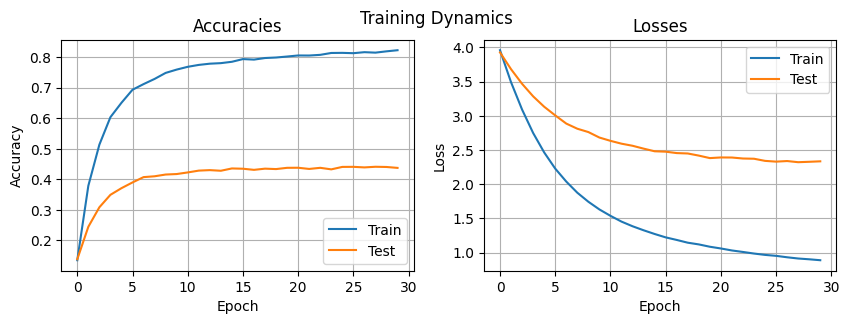

Evaluation On Test Set


AttributeError: 'FeatureTensorDataset' object has no attribute 'classes'

In [75]:
config = {'epochs':30, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-5}
train_workflow(truncated_model, cache_office_home_l3s , cache_office_home_l3t, config)

In [107]:
from dataclasses import dataclass

@dataclass
class configuration:
    epochs: int
    lr: float
    weight_decay: float 
    momentum: float
    save_path: str
    batch_size: int

args = configuration(epochs=25, lr=1e-3, weight_decay=0, momentum=0, save_path=None,batch_size= 24)


In [ ]:
# del cachedOfficeNetSourcef3 
# del cachedOfficeNetTargetf3

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline = init_model("resnet", num_classes=len(source_ds.classes), freeze_backbone=False)

In [109]:
dan_resnet = _truncate_resnet_from(baseline, layer_name='layer3')

In [110]:
saved_weights = {k: v.clone() for k, v in dan_resnet.state_dict().items()}


In [111]:
dan_resnet.load_state_dict(saved_weights)

<All keys matched successfully>

In [ ]:
def _forward_impl(self, x):
  
    f4 = self.layer4(x)

    x = torch.flatten(self.avgpool(f4), 1)
    x = self.fc(x)
    
    return x, [x, f4]

import types
dan_resnet.forward = types.MethodType(_forward_impl, dan_resnet)
loss_fn = DANLoss(sigmas=[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], scale=16)
optimizer = torch.optim.SGD(dan_resnet.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=args.momentum)

source_loader = torch.utils.data.DataLoader(cache_office_home_l3s, batch_size=args.batch_size, shuffle=True, drop_last=True)

val_ds, test_ds = torch.utils.data.random_split(cache_office_home_l3t, [0.8, 0.2])

val_loader  = torch.utils.data.DataLoader(val_ds , batch_size=args.batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=args.batch_size, shuffle=True, drop_last=True)

def accuracy_fn(logits, labels):
    return (torch.argmax(logits, dim=1) == labels).sum().item()

source_losses, supervised_losses, mkmmd_losses, train_accs, test_accs = dan_train(
    source_loader=source_loader, 
    target_loader=val_loader, 
    test_loader=test_loader,
    epochs=args.epochs,
    optimizer=optimizer,
    model=dan_resnet,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)      

Training:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/25

Train loss: 1.26540 | Supervised: 1.26060 | MK-MMD: 0.00481 | Train acc: 2.41% | Test acc=8.02%



Training:   4%|▍         | 1/25 [00:10<04:12, 10.53s/it]


Epoch 2/25

Train loss: 1.18106 | Supervised: 1.17487 | MK-MMD: 0.00619 | Train acc: 7.39% | Test acc=16.49%



Training:   8%|▊         | 2/25 [00:21<04:01, 10.50s/it]


Epoch 3/25

Train loss: 1.09791 | Supervised: 1.08908 | MK-MMD: 0.00883 | Train acc: 11.56% | Test acc=25.09%



Training:  12%|█▏        | 3/25 [00:31<03:51, 10.50s/it]


Epoch 4/25

Train loss: 1.02616 | Supervised: 1.00793 | MK-MMD: 0.01822 | Train acc: 14.30% | Test acc=31.96%



Training:  16%|█▌        | 4/25 [00:41<03:40, 10.49s/it]


Epoch 5/25

Train loss: 0.94708 | Supervised: 0.92637 | MK-MMD: 0.02071 | Train acc: 16.33% | Test acc=34.82%



Training:  20%|██        | 5/25 [00:52<03:29, 10.49s/it]


Epoch 6/25

Train loss: 0.87239 | Supervised: 0.84982 | MK-MMD: 0.02257 | Train acc: 17.70% | Test acc=37.92%



Training:  24%|██▍       | 6/25 [01:02<03:19, 10.50s/it]


Epoch 7/25

Train loss: 0.78723 | Supervised: 0.76630 | MK-MMD: 0.02093 | Train acc: 19.23% | Test acc=41.24%



Training:  28%|██▊       | 7/25 [01:13<03:08, 10.49s/it]


Epoch 8/25

Train loss: 0.72365 | Supervised: 0.70744 | MK-MMD: 0.01621 | Train acc: 19.63% | Test acc=42.15%



Training:  32%|███▏      | 8/25 [01:23<02:58, 10.49s/it]


Epoch 9/25

Train loss: 0.66598 | Supervised: 0.65146 | MK-MMD: 0.01453 | Train acc: 20.59% | Test acc=43.99%



Training:  36%|███▌      | 9/25 [01:34<02:47, 10.49s/it]


Epoch 10/25

Train loss: 0.59563 | Supervised: 0.58394 | MK-MMD: 0.01169 | Train acc: 21.38% | Test acc=44.67%



Training:  40%|████      | 10/25 [01:44<02:37, 10.49s/it]


Epoch 11/25

Train loss: 0.57072 | Supervised: 0.55939 | MK-MMD: 0.01132 | Train acc: 21.63% | Test acc=45.82%



Training:  44%|████▍     | 11/25 [01:55<02:26, 10.48s/it]


Epoch 12/25

Train loss: 0.51536 | Supervised: 0.50437 | MK-MMD: 0.01099 | Train acc: 22.53% | Test acc=47.42%



Training:  48%|████▊     | 12/25 [02:05<02:16, 10.48s/it]


Epoch 13/25

Train loss: 0.49094 | Supervised: 0.48201 | MK-MMD: 0.00893 | Train acc: 22.75% | Test acc=46.96%



Training:  52%|█████▏    | 13/25 [02:16<02:05, 10.48s/it]


Epoch 14/25

Train loss: 0.46216 | Supervised: 0.45706 | MK-MMD: 0.00510 | Train acc: 22.94% | Test acc=47.88%



Training:  56%|█████▌    | 14/25 [02:26<01:55, 10.48s/it]


Epoch 15/25

Train loss: 0.42811 | Supervised: 0.42186 | MK-MMD: 0.00625 | Train acc: 23.34% | Test acc=47.42%



Training:  60%|██████    | 15/25 [02:37<01:44, 10.48s/it]


Epoch 16/25

Train loss: 0.40972 | Supervised: 0.40354 | MK-MMD: 0.00618 | Train acc: 23.62% | Test acc=47.08%



Training:  64%|██████▍   | 16/25 [02:47<01:34, 10.48s/it]


Epoch 17/25

Train loss: 0.38628 | Supervised: 0.38033 | MK-MMD: 0.00595 | Train acc: 23.98% | Test acc=49.26%



Training:  68%|██████▊   | 17/25 [02:58<01:23, 10.48s/it]


Epoch 18/25

Train loss: 0.37601 | Supervised: 0.37184 | MK-MMD: 0.00417 | Train acc: 23.86% | Test acc=48.68%



Training:  72%|███████▏  | 18/25 [03:08<01:13, 10.48s/it]


Epoch 19/25

Train loss: 0.34815 | Supervised: 0.34544 | MK-MMD: 0.00271 | Train acc: 24.63% | Test acc=49.26%



Training:  76%|███████▌  | 19/25 [03:19<01:02, 10.47s/it]


Epoch 20/25

Train loss: 0.34604 | Supervised: 0.34068 | MK-MMD: 0.00536 | Train acc: 24.46% | Test acc=49.03%



Training:  80%|████████  | 20/25 [03:29<00:52, 10.48s/it]


Epoch 21/25

Train loss: 0.33666 | Supervised: 0.32696 | MK-MMD: 0.00970 | Train acc: 24.47% | Test acc=49.48%



Training:  84%|████████▍ | 21/25 [03:40<00:41, 10.48s/it]


Epoch 22/25

Train loss: 0.31398 | Supervised: 0.30994 | MK-MMD: 0.00404 | Train acc: 24.91% | Test acc=48.34%



Training:  88%|████████▊ | 22/25 [03:50<00:31, 10.47s/it]


Epoch 23/25

Train loss: 0.31828 | Supervised: 0.31367 | MK-MMD: 0.00461 | Train acc: 24.45% | Test acc=48.57%



Training:  92%|█████████▏| 23/25 [04:01<00:20, 10.47s/it]


Epoch 24/25

Train loss: 0.29729 | Supervised: 0.29444 | MK-MMD: 0.00285 | Train acc: 24.82% | Test acc=50.29%



Training:  96%|█████████▌| 24/25 [04:11<00:10, 10.48s/it]


Epoch 25/25

Train loss: 0.29124 | Supervised: 0.28933 | MK-MMD: 0.00190 | Train acc: 24.86% | Test acc=50.17%



Training: 100%|██████████| 25/25 [04:22<00:00, 10.48s/it]


In [ ]:
dan_loader_accuracy(target_loader, dan_resnet, accuracy_fn, device)

In [ ]:
len(test_loader.dataset)